In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
files = glob.glob('../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters/23*.txt')
files_nm = glob.glob('../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters/*nm*.txt')

#here is where the output will go 
path_save_1 = '../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters/Curve.csv'
path_save_2 = '../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters/FeT.csv'
files

['../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters\\233400P1F_Absorbance_01.txt',
 '../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters\\233400P1F_Absorbance_02.txt',
 '../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters\\233400P1F_Absorbance_03.txt',
 '../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters\\233400P6F_Absorbance_01.txt',
 '../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters\\233400P6F_Absorbance_02.txt',
 '../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters\\233400P6F_Absorbance_03.txt',
 '../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters\\233450P1F_Absorbance_01.txt',
 '../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters\\233450P1F_Absorbance_02.txt',
 '../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters\\233450P1F_Absorbance_03.txt',
 '../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters\\233450P6F_Absorbance_01.txt',
 '../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters\\233450P6F_Absorbance_02.txt',
 '../2023_Hogarth_FAU_CTD/FeT_hogerth_pore_waters\\233450P6F_Absorbance_03.txt']

In [3]:
def GET_DATA(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']
    #df['wl'] = df['wl']
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [4]:
frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index

In [5]:
frames = []
for f in files_nm:
    df_nm = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df_nm = df_nm.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df_nm = df_nm.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df_nm) # adds the new col from each scan to a part of frames 
df_nm = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df_nm['wl'] = df_nm.index

Text(0.5, 1.0, 'Iron')

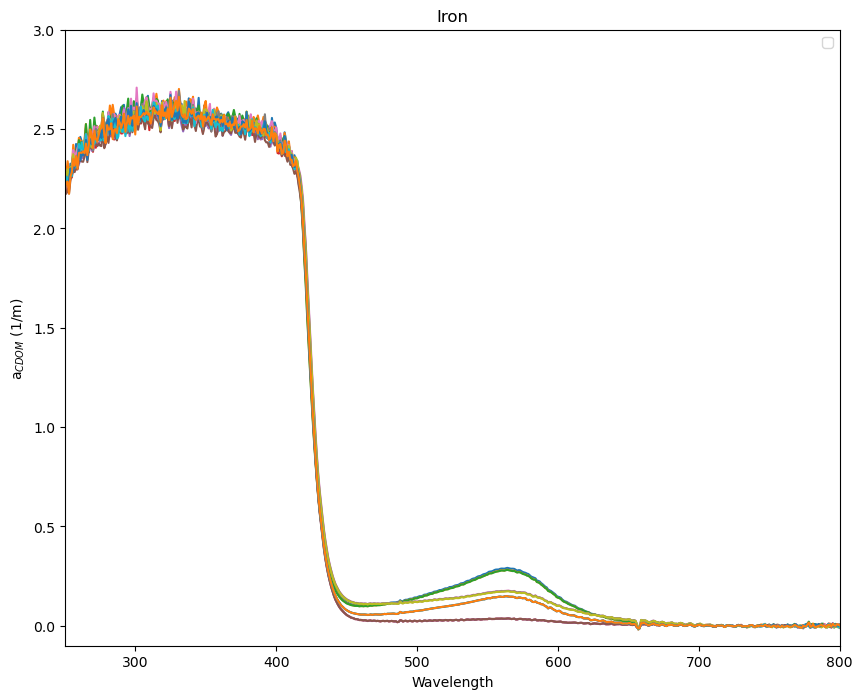

In [6]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.legend("")
ax.set_title("Iron")


Text(0.5, 1.0, 'Iron')

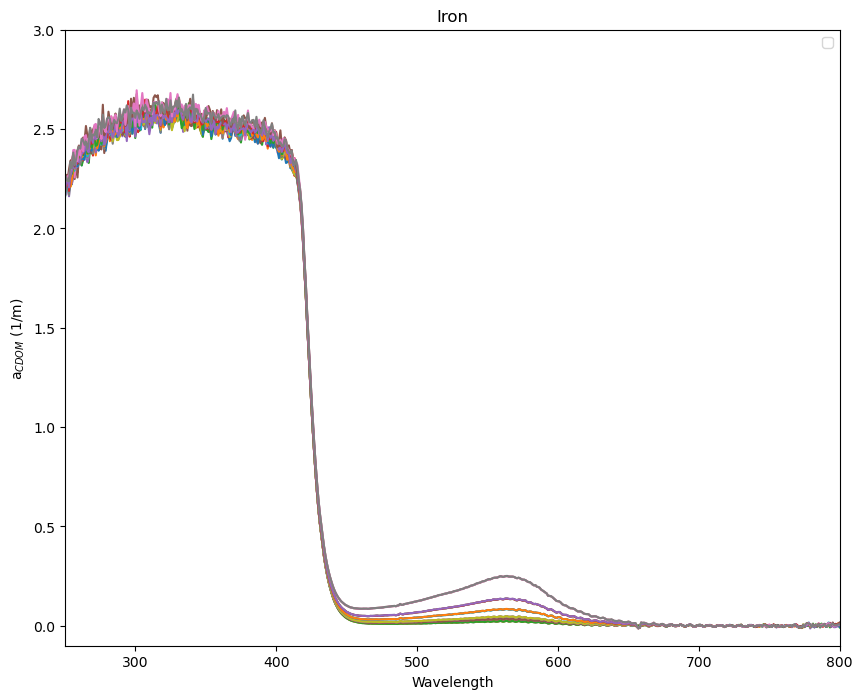

In [7]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df_nm.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.legend("")
ax.set_title("Iron")


PART 1 
THE CURVE

In [8]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df_nm.items():
    col = columnName
    
    abs_562 = df_nm[(df_nm['wl']==562)][col].mean()
    
    ydata = df_nm[(df_nm['wl']>=450) & (df_nm['wl']<=700)][col]
    xdata = df_nm[(df_nm['wl']>=450) & (df_nm['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    std_outs = pd.DataFrame(dict)
    std_outs = std_outs.set_index('sample', drop=True)
    Frames.append(std_outs)

std_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
std_outs = std_outs.drop('wl')
std_outs['conc'] = std_outs.index.str.rsplit('_', n=7).str[0].astype(int)
std_outs['ID'] = std_outs.index.str.rsplit('_', n=7).str[0]

In [9]:
#std_outs = std_outs.drop('010_nm_pre_Absorbance_12-54-26-418.txt', axis = 0)
#std_outs = std_outs.drop('020_nm_pre_Absorbance_12-57-44-229.txt', axis = 0)
#std_outs = std_outs.drop('100_nm_post_Absorbance_16-08-48-309.txt', axis = 0)
std_outs

,abs_562,intagration,conc,ID
sample,,,,
000_nm_Absorbance_01.txt,0.022821,2.888839,0,000
000_nm_Absorbance_02.txt,0.022937,2.891442,0,000
000_nm_Absorbance_03.txt,0.022184,2.824622,0,000
010_nm_Absorbance_01.txt,0.034431,4.181634,10,010
010_nm_Absorbance_02.txt,0.034683,4.276110,10,010
010_nm_Absorbance_03.txt,0.034858,4.185274,10,010
020_nm_Absorbance_01.txt,0.045315,5.350343,20,020
020_nm_Absorbance_02.txt,0.045291,5.418933,20,020
020_nm_Absorbance_03.txt,0.046142,5.431150,20,020


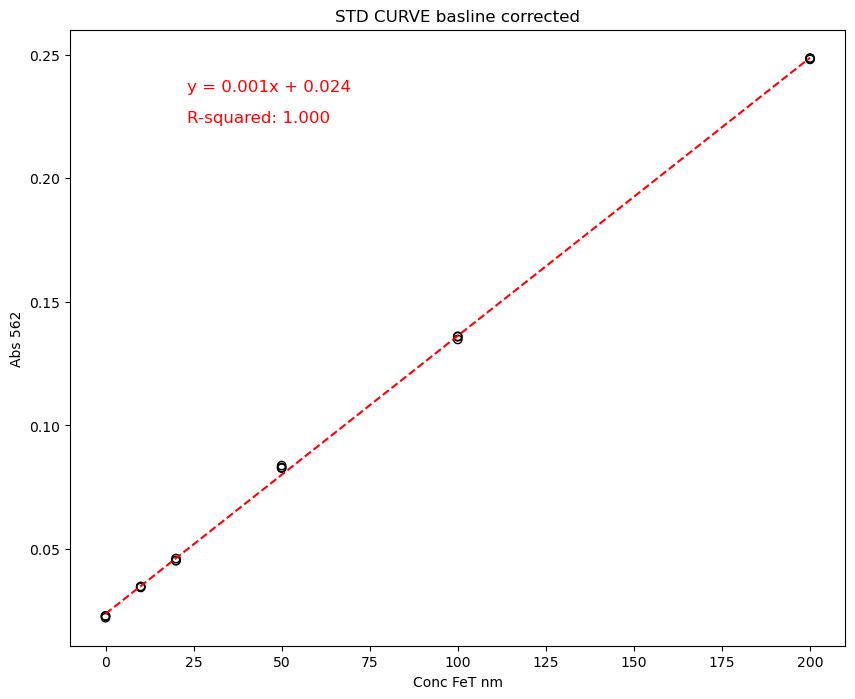

In [10]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_og1 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_og1:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()


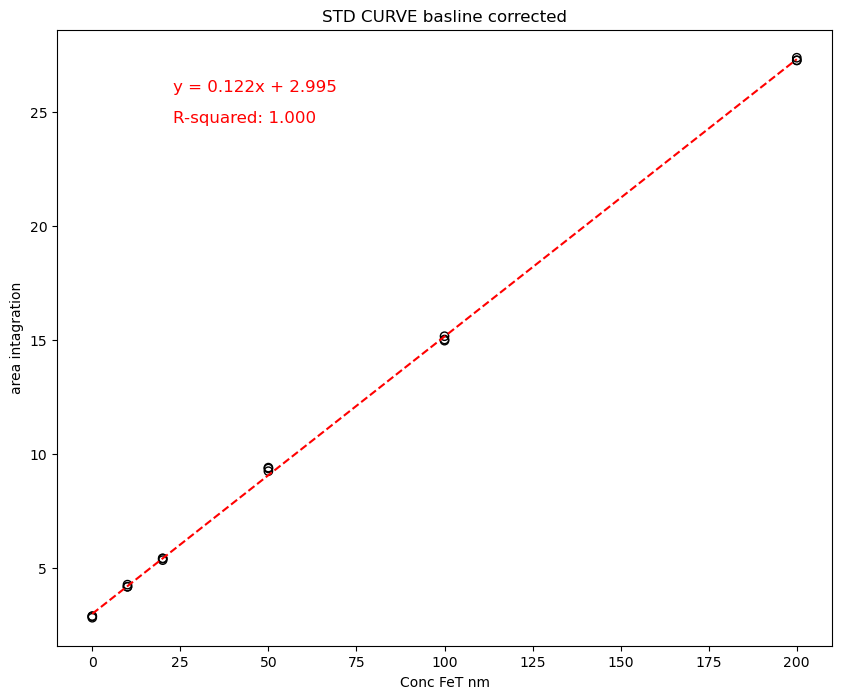

In [11]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_og2 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_og2:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()

In [12]:
# Group by the new column 'group_name', and calculate the mean and std for each group
grouped = std_outs.groupby('ID')['abs_562'].agg(['mean', 'std'])

# Join the original dataframe with the grouped one
std_outs = std_outs.join(grouped, on='ID')
std_outs["z_score"] = np.abs(std_outs['abs_562'] - std_outs['mean']) / std_outs['std']


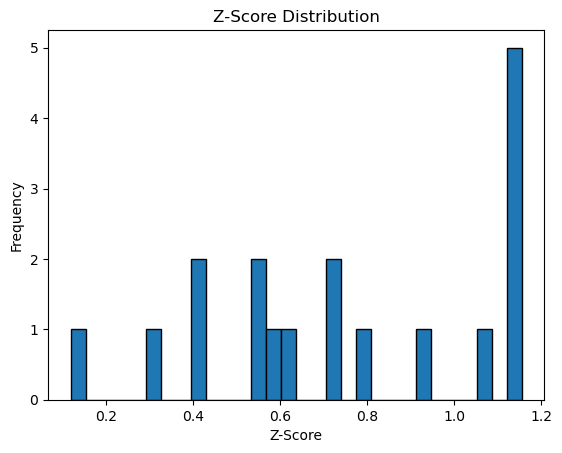

                           abs_562  intagration  conc   ID      mean  \
sample                                                                 
000_nm_Absorbance_03.txt  0.022184     2.824622     0  000  0.022647   
010_nm_Absorbance_01.txt  0.034431     4.181634    10  010  0.034657   
010_nm_Absorbance_03.txt  0.034858     4.185274    10  010  0.034657   
020_nm_Absorbance_03.txt  0.046142     5.431150    20  020  0.045583   
050_nm_Absorbance_01.txt  0.082696     9.253346    50  050  0.083137   
050_nm_Absorbance_03.txt  0.083757     9.409393    50  050  0.083137   
100_nm_Absorbance_02.txt  0.134774    14.979353   100  100  0.135564   
200_nm_Absorbance_01.txt  0.248100    27.281000   200  200  0.248419   

                               std   z_score  
sample                                        
000_nm_Absorbance_03.txt  0.000405  1.142775  
010_nm_Absorbance_01.txt  0.000214  1.053828  
010_nm_Absorbance_03.txt  0.000214  0.935675  
020_nm_Absorbance_03.txt  0.000485  1.154326

In [13]:
# Create a mask for rows that are 2 standard deviations away from the mean
mean_z = std_outs['z_score'].mean()
mask = np.abs(std_outs['z_score']) >  mean_z

plt.hist(std_outs['z_score'], bins=30, edgecolor='k')
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

# Print the rows that meet the condition
print(std_outs[mask])

In [14]:
# Group by some column, calculate mean and filter groups where max z_score > mean_z
grouped = std_outs.groupby('ID').filter(lambda x: x['z_score'].max() > mean_z)

# For each group, find the row with the maximum z_score
max_z_scores = grouped.loc[grouped.groupby('ID')['z_score'].idxmax()]

# Print the rows with the highest z_score, the z_score, and other z_scores in the group
for group, data in max_z_scores.groupby('ID'):
    print(f"Group: {group}")
    print(f"Row with highest z_score: \n{data}\n")

# Remove those rows from sub_outs
std_outs = std_outs.drop(max_z_scores.index)

Group: 000
Row with highest z_score: 
                           abs_562  intagration  conc   ID      mean  \
sample                                                                 
000_nm_Absorbance_03.txt  0.022184     2.824622     0  000  0.022647   

                               std   z_score  
sample                                        
000_nm_Absorbance_03.txt  0.000405  1.142775  

Group: 010
Row with highest z_score: 
                           abs_562  intagration  conc   ID      mean  \
sample                                                                 
010_nm_Absorbance_01.txt  0.034431     4.181634    10  010  0.034657   

                               std   z_score  
sample                                        
010_nm_Absorbance_01.txt  0.000214  1.053828  

Group: 020
Row with highest z_score: 
                           abs_562  intagration  conc   ID      mean  \
sample                                                                 
020_nm_Absorbance_03.txt

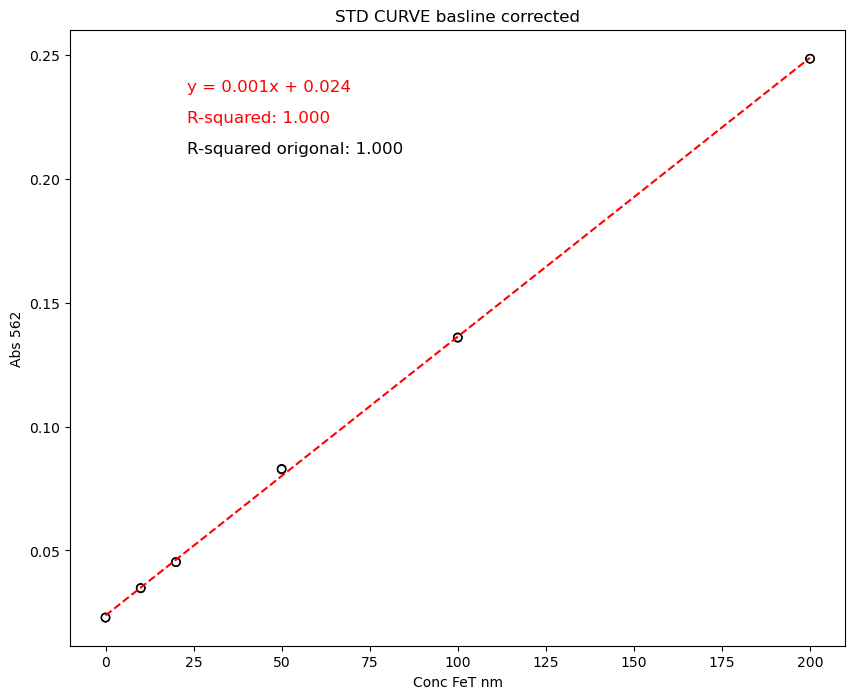

In [15]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_1 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_1:.3f}"
r2_text2 = f"R-squared origonal: {r_squared_og1:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.80, r2_text2, transform=ax.transAxes, fontsize=12, color='black')


# show plot
plt.show()


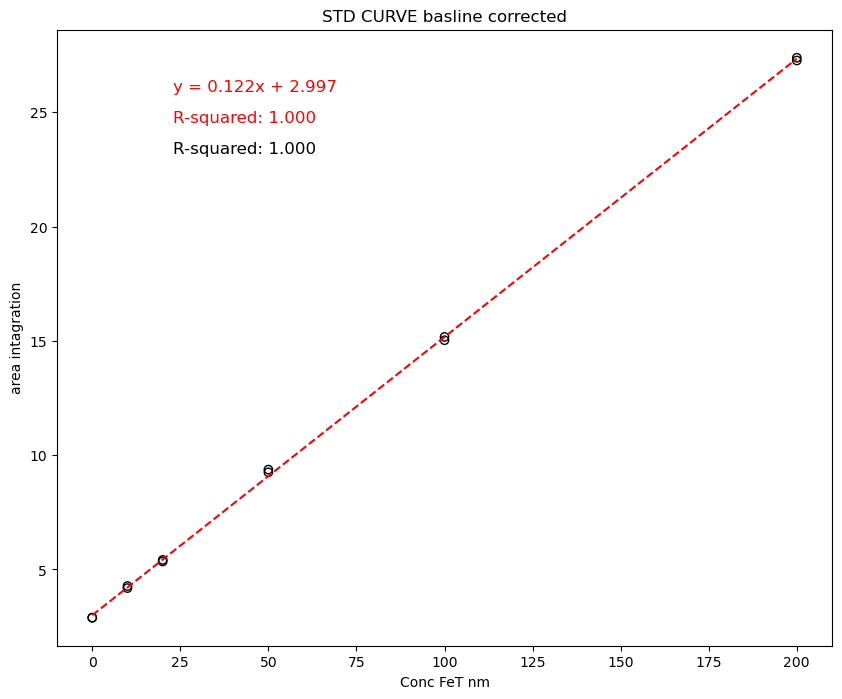

In [16]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_2 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_2:.3f}"
r2_text2 = f"R-squared: {r_squared_og2:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.80, r2_text2, transform=ax.transAxes, fontsize=12, color='black')


# show plot
plt.show()

In [17]:
std_outs

,abs_562,intagration,conc,ID,mean,std,z_score
sample,,,,,,,
000_nm_Absorbance_01.txt,0.022821,2.888839,0,000,0.022647,0.000405,0.428037
000_nm_Absorbance_02.txt,0.022937,2.891442,0,000,0.022647,0.000405,0.714738
010_nm_Absorbance_02.txt,0.034683,4.276110,10,010,0.034657,0.000214,0.118153
010_nm_Absorbance_03.txt,0.034858,4.185274,10,010,0.034657,0.000214,0.935675
020_nm_Absorbance_01.txt,0.045315,5.350343,20,020,0.045583,0.000485,0.551712
020_nm_Absorbance_02.txt,0.045291,5.418933,20,020,0.045583,0.000485,0.602615
050_nm_Absorbance_01.txt,0.082696,9.253346,50,050,0.083137,0.000552,0.799813
050_nm_Absorbance_02.txt,0.082960,9.371247,50,050,0.083137,0.000552,0.321359
100_nm_Absorbance_01.txt,0.136060,15.030146,100,100,0.135564,0.000691,0.717159


In [18]:
# Set 'conc' as the index of the DataFrame
std_outs.set_index('ID', inplace=True)

# Group by index, calculate the mean of all the columns for each group and convert it to a new DataFrame
std_outs_mean = std_outs.groupby(std_outs['conc']).mean()

# Now, mean_df is a new DataFrame with the mean of all the columns for each group
std_outs_mean.to_csv(path_save_1)
std_outs_mean

,abs_562,intagration,mean,std,z_score
conc,,,,,
0,0.022879,2.890141,0.022647,0.000405,0.571387
10,0.034770,4.230692,0.034657,0.000214,0.526914
20,0.045303,5.384638,0.045583,0.000485,0.577163
50,0.082828,9.312297,0.083137,0.000552,0.560586
100,0.135959,15.102519,0.135564,0.000691,0.571164
200,0.248579,27.331585,0.248419,0.000277,0.577195


PART 2
THE DATA

In [19]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.items():
    col = columnName
    
    abs_562 = df[(df['wl']==562)][col].mean()
    
    ydata = df[(df['wl']>=450) & (df['wl']<=700)][col]
    xdata = df[(df['wl']>=450) & (df['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    sub_outs = pd.DataFrame(dict)
    sub_outs = sub_outs.set_index('sample', drop=True)
    Frames.append(sub_outs)

sub_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
mask = sub_outs.index.str.contains('nm')
sub_outs = sub_outs[~mask]
sub_outs = sub_outs.drop('wl')
sub_outs

,abs_562,intagration
sample,,
233400P1F_Absorbance_01.txt,0.287735,32.124409
233400P1F_Absorbance_02.txt,0.278220,31.095996
233400P1F_Absorbance_03.txt,0.277500,31.036865
233400P6F_Absorbance_01.txt,0.035164,5.123013
233400P6F_Absorbance_02.txt,0.035071,5.163837
233400P6F_Absorbance_03.txt,0.036362,5.229711
233450P1F_Absorbance_01.txt,0.175682,24.448061
233450P1F_Absorbance_02.txt,0.174133,24.312457
233450P1F_Absorbance_03.txt,0.172246,23.967801


In [20]:
# Create a new column 'group_name' that contains the name you're grouping by
sub_outs['group_name'] = sub_outs.index.str.rsplit('_', n=7).str[0]

# Group by the new column 'group_name', and calculate the mean and std for each group
grouped = sub_outs.groupby('group_name')['abs_562'].agg(['mean', 'std'])

# Join the original dataframe with the grouped one
sub_outs = sub_outs.join(grouped, on='group_name')
sub_outs["z_score"] = np.abs(sub_outs['abs_562'] - sub_outs['mean']) / sub_outs['std']

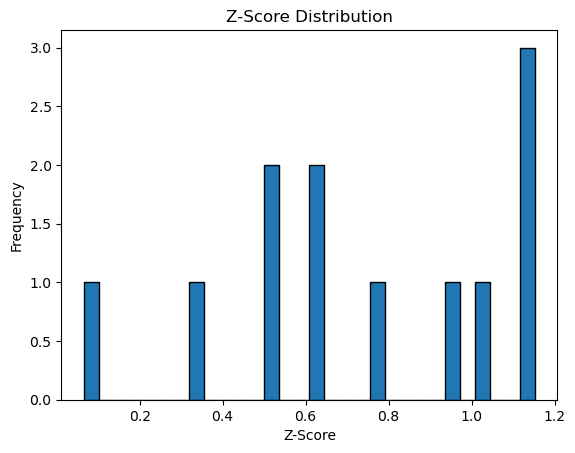

                              abs_562  intagration group_name      mean  \
sample                                                                    
233400P1F_Absorbance_01.txt  0.287735    32.124409  233400P1F  0.281152   
233400P6F_Absorbance_03.txt  0.036362     5.229711  233400P6F  0.035532   
233450P1F_Absorbance_01.txt  0.175682    24.448061  233450P1F  0.174020   
233450P1F_Absorbance_03.txt  0.172246    23.967801  233450P1F  0.174020   
233450P6F_Absorbance_01.txt  0.148076    16.622295  233450P6F  0.147852   
233450P6F_Absorbance_03.txt  0.147527    16.622174  233450P6F  0.147852   

                                  std   z_score  
sample                                           
233400P1F_Absorbance_01.txt  0.005713  1.152401  
233400P6F_Absorbance_03.txt  0.000720  1.152320  
233450P1F_Absorbance_01.txt  0.001721  0.965560  
233450P1F_Absorbance_03.txt  0.001721  1.031205  
233450P6F_Absorbance_01.txt  0.000288  0.774518  
233450P6F_Absorbance_03.txt  0.000288  1.128940  

In [21]:
# Create a mask for rows that are 2 standard deviations away from the mean
mean_z = sub_outs['z_score'].mean()
mask = np.abs(sub_outs['z_score']) >  mean_z

plt.hist(sub_outs['z_score'], bins=30, edgecolor='k')
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

# Print the rows that meet the condition
sub_outs[mask]
print(sub_outs[mask])

In [22]:
# Group by some column, calculate mean and filter groups where max z_score > mean_z
grouped = sub_outs.groupby('group_name').filter(lambda x: x['z_score'].max() > mean_z)

# For each group, find the row with the maximum z_score
max_z_scores = grouped.loc[grouped.groupby('group_name')['z_score'].idxmax()]

# Print the rows with the highest z_score, the z_score, and other z_scores in the group
for group, data in max_z_scores.groupby('group_name'):
    print(f"Group: {group}")
    print(f"Index of row with highest z_score: \n{data.index}\n")
    print(f"Other z_scores in group: \n{grouped.loc[grouped['group_name'] == group, 'z_score']}\n")

# Remove those rows from sub_outs
sub_outs = sub_outs.drop(max_z_scores.index)

Group: 233400P1F
Index of row with highest z_score: 
Index(['233400P1F_Absorbance_01.txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
233400P1F_Absorbance_01.txt    1.152401
233400P1F_Absorbance_02.txt    0.513121
233400P1F_Absorbance_03.txt    0.639280
Name: z_score, dtype: float64

Group: 233400P6F
Index of row with highest z_score: 
Index(['233400P6F_Absorbance_03.txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
233400P6F_Absorbance_01.txt    0.511981
233400P6F_Absorbance_02.txt    0.640339
233400P6F_Absorbance_03.txt    1.152320
Name: z_score, dtype: float64

Group: 233450P1F
Index of row with highest z_score: 
Index(['233450P1F_Absorbance_03.txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
233450P1F_Absorbance_01.txt    0.965560
233450P1F_Absorbance_02.txt    0.065646
233450P1F_Absorbance_03.txt    1.031205
Name: z_score, dtype: float64

Group: 233450P6F
Index of row with highest z_score: 
Index(['233450P6F_Absor

In [23]:
# Set 'conc' as the index of the DataFrame
sub_outs.set_index('group_name', inplace=True)

# Group by index, calculate the mean of all the columns for each group and convert it to a new DataFrame
sub_outs_mean = sub_outs.groupby(sub_outs.index).mean()

# Now, mean_df is a new DataFrame with the mean of all the columns for each group
sub_outs_mean.to_csv(path_save_2)
sub_outs_mean

,abs_562,intagration,mean,std,z_score
group_name,,,,,
233400P1F,0.277860,31.066430,0.281152,0.005713,0.576200
233400P6F,0.035118,5.143425,0.035532,0.000720,0.576160
233450P1F,0.174908,24.380259,0.174020,0.001721,0.515603
233450P6F,0.148015,16.617073,0.147852,0.000288,0.564470


In [ ]:
XXXXXXXXXXX

In [32]:
import pandas as pd

# Read the CSV files
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', index_col=0)
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/HANNA_IRON_RERUN_10-02-2023_RUN_2.csv', index_col=0)

# Convert the index columns of both dataframes to type object
df_meta.index = df_meta.index.astype('str')
df_iron.index = df_iron.index.astype('str')


# Pull matching values based on the index
result = df_iron.merge(df_meta[['Trip', 'Date', 'Station', 'Sample_depth']], left_index=True, right_index=True, how='left')

# Create a new DataFrame with only the desired columns in the specified order
final_df = result[['Trip', 'Date', 'Station', 'Sample_depth']]

# If you want to save this result to a new CSV:
final_df.to_csv('../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/Data_HANNA_IRON_RERUN_10-02-2023_RUN_2.csv')
final_df


,Trip,Date,Station,Sample_depth
group_name,,,,
221437,GOM22SP,4/10/2022,St.7,12.12
212834,GOM2021,7/25/2021,St.11,621
212836,GOM2021,7/25/2021,St.11,180
212933,GOM2021,7/26/2021,St.7,35
213032,GOM2021,7/27/2021,St.ML,14.5
...,...,...,...,...
MS221835,NaN,NaN,NaN,NaN
MS224533,NaN,NaN,NaN,NaN
MS224838,NaN,NaN,NaN,NaN
